In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'cs231n/cs231n-project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME

# # this downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/cs231n/cs231n-project


In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from mie2c.e2c import E2C, compute_loss, PWATransition
from mie2c.ball_model import (get_ball_encoder, get_ball_decoder,
    get_ball_transition, get_ball_linear_transition, get_ball_pwa_transition)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Method to create (3,32,32) tensor

In [0]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [0]:
def step(x0, Ak, add_noise=False):
    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [0]:
n = 4 
dh = 0.05

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32

# Training data
NUM_DATA = 500

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

# Test data
NUM_TEST = 100

X_test = np.zeros((NUM_TEST,3,W,W))
X_next_test = np.zeros((NUM_TEST,3,W,W))

count = 0
while count < NUM_TEST:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X_test[count,:,:,:] = img
    X_next_test[count,:,:,:] = img_new

    count += 1

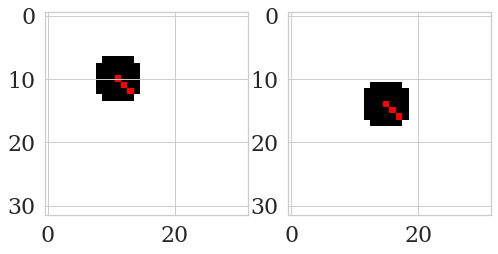

In [7]:
idx = np.random.randint(NUM_DATA)
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

### Construct encoder/decoder

In [0]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0
use_cuda = True

# encoder = get_ball_encoder(dim_in, dim_z)

# # transition = get_ball_transition(dim_z, dim_u)
# transition = get_ball_linear_transition(dim_z, dim_u, low_rank=True)
# # transition = get_ball_pwa_transition(1, dim_z, dim_u)

# decoder = get_ball_decoder(dim_z, dim_in) 

# gpu = 1
# model = E2C(encoder, transition, decoder)
# # model.to(gpu);

In [0]:
def train_vae(model, X, X_next, model_name, verbose=True, cuda=False):
    if not os.path.exists('pytorch_single_integrator'):
        os.makedirs('pytorch_single_integrator')
    fn_pt_model = 'pytorch_single_integrator/{}.pt'.format(model_name)
    dim_u = model.trans.dim_u

    # training parameters
    TRAINING_ITERATIONS = int(2000)
    BATCH_SIZE = int(64)
    CHECKPOINT_AFTER = int(400)
    SAVEPOINT_AFTER = int(1000)

    KL_LAMBDA = .25
    TEMP_LAMBDA = 10.

    if cuda:
        dataset = torch.utils.data.TensorDataset(torch.tensor(X).float().to("cuda"), \
                                                 torch.tensor(X_next).float().to("cuda"))
        model = model.to("cuda")
    else:
        dataset = torch.utils.data.TensorDataset(torch.tensor(X).float(), \
                                                 torch.tensor(X_next).float())
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters())

    itr = 0
    for epoch in range(TRAINING_ITERATIONS):
        iter_count = 0
        for x, x_next in dataloader:
            optimizer.zero_grad()
            action = torch.empty(NUM_DATA, dim_u)

            model(x, action, x_next)
            elbo_loss, kl_loss = compute_loss(model.x_dec, None, model.x_next_pred_dec,
                                              x, x_next,
                                              model.Qz, model.Qz_next, model.Qz_next_pred)
            loss = elbo_loss # + KL_LAMBDA * kl_loss
            if isinstance(model.trans, PWATransition):
                loss += TEMP_LAMBDA * model.trans.temperature.pow(2)[0]

            loss.backward()
            optimizer.step()

            if itr % CHECKPOINT_AFTER == 0:
                print('Avg. loss: {}'.format(loss.item()))

            # if itr % SAVEPOINT_AFTER == 0:
            #     torch.save(model.state_dict(), fn_pt_model)

            iter_count += 1
            itr += 1

    if cuda:
        model = model.to("cpu")          
        torch.cuda.empty_cache()
    del dataset

    torch.save(model.state_dict(), fn_pt_model)

In [0]:
encoder = get_ball_encoder(dim_in, dim_z)
e2c_transition   = get_ball_transition(dim_z, dim_u)
decoder = get_ball_decoder(dim_z, dim_in)

fn_e2c = 'model_e2c'
model_e2c = E2C(encoder, e2c_transition, decoder)

if os.path.exists('pytorch_single_integrator/{}.pt'.format(fn_e2c)):
    model_e2c.load_state_dict(torch.load('pytorch_single_integrator/{}.pt'.format(fn_e2c)))

In [16]:
train_vae(model_e2c, X, X_next, fn_e2c, verbose=True, cuda=use_cuda)

Avg. loss: 2430.2748552040657
Avg. loss: 129.38839901920625
Avg. loss: 109.91222135062537
Avg. loss: 52.23914629129873
Avg. loss: 32.62281593170403
Avg. loss: 23.60730399812845
Avg. loss: 21.231251381345032
Avg. loss: 20.944101775208942
Avg. loss: 18.691537487653264
Avg. loss: 15.069743550780178
Avg. loss: 16.32684324990549
Avg. loss: 12.338755214773462
Avg. loss: 11.543319023553
Avg. loss: 12.037808454563315
Avg. loss: 9.400557686855997
Avg. loss: 9.50670768186395
Avg. loss: 9.05443828898867
Avg. loss: 47.940955876204754
Avg. loss: 16.26469597201077
Avg. loss: 7.749002629055111
Avg. loss: 10.709245254618832
Avg. loss: 7.948550827108172
Avg. loss: 16.65465418339141
Avg. loss: 4.775470759871455
Avg. loss: 4.87148454366991
Avg. loss: 4.416100579576163
Avg. loss: 7.9431677603824635
Avg. loss: 4.593289560836837
Avg. loss: 15.32682182656929
Avg. loss: 4.548079843380529
Avg. loss: 4.158706981596517
Avg. loss: 5.85315063017099
Avg. loss: 7.197541098680547
Avg. loss: 4.020353203246555
Avg. los

In [0]:
use_low_rank = False  # True if A = I + r*v^T

encoder = get_ball_encoder(dim_in, dim_z)
lin_transition = get_ball_linear_transition(dim_z, dim_u, low_rank=use_low_rank)
decoder = get_ball_decoder(dim_z, dim_in) 

fn_lin = 'model_lin'
model_lin = E2C(encoder, lin_transition, decoder)

if os.path.exists('pytorch_single_integrator/{}.pt'.format(fn_lin)):
    model_lin.load_state_dict(torch.load('pytorch_single_integrator/{}.pt'.format(fn_lin)))

In [18]:
train_vae(model_lin, X, X_next, fn_lin  , verbose=True, cuda=use_cuda)

Avg. loss: 2282.992714101009
Avg. loss: 127.22532690048688
Avg. loss: 123.70648523844196
Avg. loss: 113.52575820619295
Avg. loss: 110.83367189754169
Avg. loss: 101.1925844797479
Avg. loss: 80.35752101560453
Avg. loss: 36.859357701090154
Avg. loss: 23.932166952746165
Avg. loss: 20.385644834346085
Avg. loss: 17.551625701938868
Avg. loss: 14.62676106641782
Avg. loss: 13.682723475300852
Avg. loss: 12.661365323685752
Avg. loss: 9.046390526231828
Avg. loss: 9.037961497596296
Avg. loss: 8.13144715970893
Avg. loss: 11.168423322381894
Avg. loss: 6.768274066325689
Avg. loss: 5.9370520802369
Avg. loss: 12.055626369846367
Avg. loss: 17.59408962131396
Avg. loss: 5.352088154009641
Avg. loss: 4.524780507886627
Avg. loss: 14.204342882592968
Avg. loss: 10.997849307520283
Avg. loss: 6.796422773326693
Avg. loss: 4.468849664539958
Avg. loss: 5.716761472212557
Avg. loss: 5.380451029484528
Avg. loss: 4.561106577306456
Avg. loss: 4.137818461960622
Avg. loss: 3.9836353922106222
Avg. loss: 4.803186429203928
Av

In [0]:
use_low_rank = False  # True if A = I + r*v^T
num_modes = 6

encoder = get_ball_encoder(dim_in, dim_z)
pwa_transition = get_ball_pwa_transition(num_modes, dim_z, dim_u, low_rank=use_low_rank)
decoder = get_ball_decoder(dim_z, dim_in) 

fn_pwa = 'model_pwa'
model_pwa = E2C(encoder, pwa_transition, decoder)

# if os.path.exists('pytorch_single_integrator/{}.pt'.format(fn_pwa)):
#     model_pwa.load_state_dict(torch.load('pytorch_single_integrator/{}.pt'.format(fn_pwa)))

In [49]:
train_vae(model_pwa, X, X_next, fn_pwa, verbose=True, cuda=use_cuda)

Avg. loss: 2541.102952888642
Avg. loss: 136.08751077150183
Avg. loss: 132.70243374794833
Avg. loss: 128.6779624335697
Avg. loss: 118.90049238498361
Avg. loss: 106.63196839324735
Avg. loss: 68.49450461540384
Avg. loss: 34.94626453399023
Avg. loss: 29.007080503910093
Avg. loss: 23.93894476679592
Avg. loss: 22.201467600878512
Avg. loss: 20.15283698918133
Avg. loss: 15.320468906872321
Avg. loss: 17.324771151754913
Avg. loss: 15.52082292721716
Avg. loss: 12.549059561875245
Avg. loss: 11.930258872186686
Avg. loss: 10.485174527239892
Avg. loss: 9.504311296783133
Avg. loss: 10.867275162479757
Avg. loss: 29.866274196746716
Avg. loss: 10.393148970687534
Avg. loss: 7.411772126999908
Avg. loss: 8.582712068118648
Avg. loss: 12.116123645056469
Avg. loss: 7.835743296951019
Avg. loss: 7.966470641388231
Avg. loss: 6.586073494402185
Avg. loss: 5.414779097125569
Avg. loss: 17.397273124391564
Avg. loss: 8.361258740439249
Avg. loss: 6.63298185977827
Avg. loss: 5.587916372214254
Avg. loss: 4.916396694560901

In [54]:
x_pred_e2c = model_e2c.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_e2c = (x_pred_e2c - torch.tensor(X_next_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

x_pred_lin = model_lin.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_lin = (x_pred_lin - torch.tensor(X_next_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

x_pred_pwa = model_pwa.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_pwa = (x_pred_pwa - torch.tensor(X_next_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

print("e2c: " + str(l2_err_e2c.mean()))
print("linear: " + str(l2_err_lin.mean()))
print("pwa: " + str(l2_err_pwa.mean()))

e2c: 4.882538069357531
linear: 3.062171600047086
pwa: 3.5613505390213818


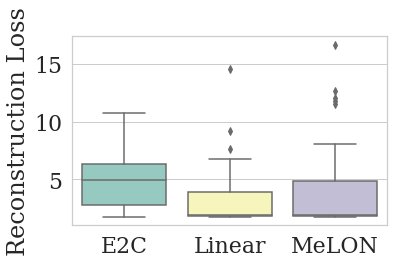

In [55]:
import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

results = {'E2C':l2_err_e2c, 'Linear':l2_err_lin, 'MeLON':l2_err_pwa}
results = pd.DataFrame(results)

ax1 = sns.boxplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Reconstruction Loss")

plt.tight_layout()
# plt.ylim(0, int(math.ceil(np.max(np.maximum(l2_err_lin, l2_err_e2c, l2_err_pwa)) / 10.0)) * 10)

figure = ax1.get_figure()
figure.savefig("loss.pdf")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


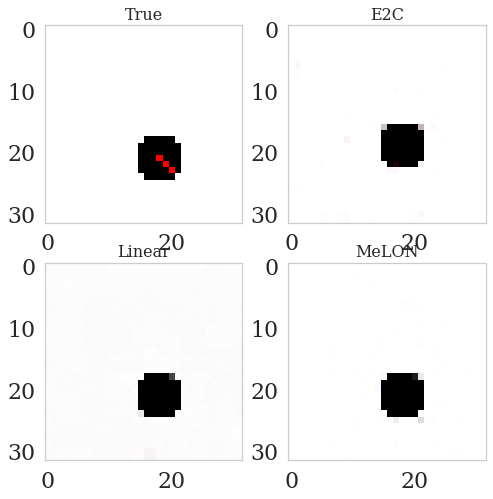

In [59]:
idx = np.random.randint(NUM_TEST)

img, img_next = X_test[idx,:,:,:], X_next_test[idx,:,:,:]
img_e2c = x_pred_e2c[idx,:,:,:].detach().cpu().numpy()
img_lin = x_pred_lin[idx,:,:,:].detach().cpu().numpy()
img_pwa = x_pred_pwa[idx,:,:,:].detach().cpu().numpy()

fig = plt.figure(figsize=(8,8))

# fig.add_subplot(3,2,1)
# plt.imshow(img.transpose(1,2,0))
# plt.title('prev', fontsize=16)
# plt.grid(False)
# # plt.axis('off')

fig.add_subplot(2,2,1)
plt.imshow(img_next.transpose(1,2,0))
plt.title('True', fontsize=16)
plt.grid(False)
# plt.axis('off')

fig.add_subplot(2,2,2)
plt.imshow(img_e2c.transpose(1,2,0))
plt.title('E2C', fontsize=16)
plt.grid(False)
# plt.axis('off')

fig.add_subplot(2,2,3)
plt.imshow(img_lin.transpose(1,2,0))
plt.title('Linear', fontsize=16)
plt.grid(False)
# plt.axis('off')

fig.add_subplot(2,2,4)
plt.imshow(img_pwa.transpose(1,2,0))
plt.title('MeLON', fontsize=16)
plt.grid(False)
# plt.axis('off')